In [33]:
# !pip install mrob
!pip install matplotlib --upgrade
!pip install scipy --upgrade
# new comment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
import numpy as np
from numpy import cos, sin, arctan2
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.ticker import LinearLocator
import cvxpy as cp
from scipy.optimize import least_squares, minimize
import networkx as nx
# import mrob
import pandas as pd
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [35]:
class Landmark():
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id
    def get_data(self):
        return np.array([self.x, self.y, self.id])
    
class Pose():
    def __init__(self, x, y, phi):
        self.x = x
        self.y = y
        self.phi = wrap_angle(phi)
        
    def get_data(self):
        return np.array([self.x, self.y, self.phi])
    
    def set_data(self, x, y, phi):
        self.x = x
        self.y = y
        self.phi = wrap_angle(phi)

In [36]:
def wrap_angle(angle):
      while angle > np.pi:
        angle -= 2.0 * np.pi
      while angle < -np.pi:
        angle += 2.0 * np.pi
      return angle

def get_R(phi):
    phi = wrap_angle(phi)
    R = np.array([[cos(phi),-sin(phi),0],
                  [sin(phi), cos(phi),0],
                      [0,      0,     1]])
    return R

def get_g(pose_i, measurement):
    rot1, trans, rot2 = measurement[0],measurement[1],measurement[2]
    phi = pose_i.get_data()[2]
    delta = np.array([trans*cos(wrap_angle(phi+rot1)),trans*sin(wrap_angle(phi+rot1)),wrap_angle(rot1+rot2)])
    g = pose_i.get_data() + delta
    return g

    
def get_G(pose_i, measurement):
    rot1, trans, rot2 = measurement[0],measurement[1],measurement[2]
    phi = pose_i.get_data()[2]
    G = np.array([[[1],[0],[-trans*sin(wrap_angle(phi+rot1))]],
                  [[0],[1],[ trans*cos(wrap_angle(phi+rot1))]],
                  [[0],[0],         [1]]])
    return G.squeeze()

def get_h(pose_i, pose_j):
    dx = pose_j.get_data()[0]-pose_i.get_data()[0]
    dy = pose_j.get_data()[1]-pose_i.get_data()[1]
    d_phi = pose_j.get_data()[2]-pose_i.get_data()[2]
    phi_i = pose_i.get_data()[2]
    delta_X = np.array([dx,dy,d_phi])
    R = get_R(phi_i)
    return R.T @ delta_X

def get_H(pose_i, pose_j):
    dx = pose_j.get_data()[0]-pose_i.get_data()[0]
    dy = pose_j.get_data()[1]-pose_i.get_data()[1]
    phi_i = pose_i.get_data()[2]

    H = np.array([[[-cos(phi_i)],[-sin(phi_i)],[-dx*sin(phi_i)+dy*cos(phi_i)]],
                  [[sin(phi_i)], [-cos(phi_i)],[-dx*cos(phi_i)-dy*sin(phi_i)]],
                  [[0],            [0],               [-1]]])
    
    return H.squeeze()

In [37]:
def generate_poses(amount):
    poses = []
    for i in range(amount):
        poses.append(Pose(0,0,0))
    return poses

def generate_odom_measurements_mrob(GT_traj, noises):
  measurements = np.zeros(shape=(GT_traj.shape[0]-1,3))
  for i in range(measurements.shape[0]):
      d_trans = np.sqrt((GT_traj[i+1,0]-GT_traj[i,0])**2 + (GT_traj[i+1,1]-GT_traj[i,1])**2)
      d_rot1 = arctan2(GT_traj[i+1,1]-GT_traj[i,1],GT_traj[i+1,0]-GT_traj[i,0])-GT_traj[i,2]
      d_rot2 = wrap_angle(GT_traj[i+1,2]-GT_traj[i,2]-d_rot1)
      measurements[i,0] = d_rot1 + np.random.normal(loc=0.0, scale=noises[2], size=1)
      measurements[i,1] = d_trans + np.random.normal(loc=0.0, scale=noises[0], size=1)
      measurements[i,2] = d_rot2 + np.random.normal(loc=0.0, scale=noises[2], size=1)
      measurements[i,2] = wrap_angle(measurements[i,2])
  return measurements

def integrate_measurements(start_pose, measurements):
    poses = np.zeros(shape=(measurements.shape[0]+1,3))
    poses[0,:] = start_pose
    for i in range(measurements.shape[0]):
        rot1, trans, rot2 = measurements[i,0],measurements[i,1],measurements[i,2]
        phi = poses[i,2]
        delta = np.array([trans*cos(phi+rot1),trans*sin(phi+rot1),rot1+rot2])
        poses[i+1] = poses[i,:] + delta
        poses[i+1,2] = wrap_angle(poses[i+1,2])
    return poses

In [38]:
class RS_element:
    def __init__(self):
        self.type = "s"
        self.start_point = [0,0]
        self.length = 0
        
class Path:
    def __init__(self):
        self.rs_elements = []
        self.path_points = []
        
def generate_odom(poses):
    measurments_amount = poses.shape[0]-1
    measurements = np.zeros(shape=(measurments_amount,3))
    for i in range(measurments_amount):
        measurements[i,:] = poses[i+1,:] - poses[i,:]
    return measurements

def make_trajectory(elem_types, start, sigma_xy, sigma_theta):
    np.random.seed(0)
    MAX_STEER = 0.6
    CAR_LENGTH = 1.5
    RESOLUTION = 0.2
    U_MAX = 0.5#np.tan(MAX_STEER) / CAR_LENGTH
    

    def move(x, y, yaw, distance, u):
        noise_x = np.random.normal(loc=0, scale=sigma_xy, size=1)[0]
        noise_y = np.random.normal(loc=0, scale=sigma_xy, size=1)[0]
        noise_yaw = np.random.normal(loc=0, scale=sigma_theta, size=1)[0]
        x += distance * cos(yaw)+ noise_x
        y += distance * sin(yaw)+ noise_y
        yaw = wrap_angle(yaw + distance * u)+ noise_yaw
        return x, y, yaw
    
    path_point = [start]
    x, y, yaw = start
    trajectory_types = elem_types
    trajectory = Path()
    for rs_elem in trajectory_types:
        elem = RS_element()
        elem.type = rs_elem[0]
        elem.length = rs_elem[1]
        elem.start_point = [x,y, yaw]
        trajectory.rs_elements.append(elem)
        if(elem.type =="r"):
            u = -U_MAX
        elif(elem.type =="l"):
            u = U_MAX
        else:
            u = 0

        length = 0
        while length <  abs(elem.length):
            x,y, yaw = move(x, y, yaw, RESOLUTION*np.sign(rs_elem[1]), u)
            length+=RESOLUTION
            path_point.append([x,y, yaw ])
            
    path_point = np.array(path_point)  
    trajectory.path_points = path_point
    return trajectory

In [39]:
def LM_solver(A, b, poses):
    def func(x, A, b):
        return np.power((A @ x - b),2)
    solution = least_squares(func, x0=poses, args=(A,b),  method='lm')
    return solution.x

In [40]:
def MSE(GT_traj, traj):
  mse_rot = np.mean(np.power((GT_traj[:,2]-traj[:,2]),2))
  mse_trans = np.mean(np.power((GT_traj[:,:2]-traj[:,:2]),2))
  return mse_trans, mse_rot

In [41]:
def generate_loop_measurements(trajectory_GT, k=5):
    m = trajectory_GT.shape[0] // k
    loops = []
    random_i = np.random.randint(low=0, high=trajectory_GT.shape[0], size=m)[None, :]
    random_j = np.random.randint(low=0, high=trajectory_GT.shape[0], size=m)[None, :]
    random_loop_idxs = np.vstack((random_i, random_j))
    random_loop_idxs = random_loop_idxs[:, ~np.all(random_loop_idxs[1:] == random_loop_idxs[:-1], axis=0)] # removing duplicate idxs

    for i in range(random_loop_idxs.shape[1]):
      # idx_i = random_loop_idxs[0,i]
      idx_i = 0
      idx_j = random_loop_idxs[1,i]
      phi = trajectory_GT[idx_i][2]
      R_T = np.array([[cos(phi),  sin(phi),  0],
                     [-sin(phi), cos(phi),  0],
                     [0,           0,       1]])
      loops.append(np.array([idx_i, idx_j, *(R_T @ (trajectory_GT[idx_j] - trajectory_GT[idx_i]))])[None,:])

    loop_measurements = np.array(loops).reshape((len(loops)*loops[0].shape[0] , -1))
    return loop_measurements

In [42]:
def make_H(pose_i, pose_j, idx_i, idx_j):
    dx, dy = (pose_j.get_data() - pose_i.get_data())[:-1]
    phi = pose_i.get_data()[2]
    
    H_i = np.array([[-cos(phi), -sin(phi),  -sin(phi)*dx + cos(phi)*dy],
                    [ sin(phi), -cos(phi),  -cos(phi)*dx - sin(phi)*dy],
                    [0,           0,                                -1]])
    
    H_j = np.array([[cos(phi),  sin(phi),  0],
                    [-sin(phi), cos(phi),  0],
                    [0,           0,       1]])

    return H_i, H_j
    
def make_A(poses, odom_measurements, odom_covariance, loop_measurements, loop_covariance):

    def add_odom_factor(poses, idx,  odom_measurements, odom_E, A, b):
        k = odom_measurements.shape[0]
        A = np.pad(A, ((0,3*k),(0,3)), mode='constant', constant_values=0)
        for i in range(k):
          pose_i_idx, pose_j_idx = idx, idx+1
          pose_i, pose_j = poses[pose_i_idx], poses[pose_j_idx]
          G = get_G(pose_i, odom_measurements[i, idx, :])
          g = get_g(pose_i, odom_measurements[i, idx, :])

          row_i, row_j = -3*k+3*i, -3*k+3*(i+1)
          if(row_j == 0):
              A[row_i : , 3*pose_i_idx:3*(pose_i_idx+1)] = odom_E[i,:,:] @ G
              A[row_i : , 3*pose_j_idx:3*(pose_j_idx+1)] = odom_E[i,:,:] @ -I
          else:
              A[row_i : row_j, 3*pose_i_idx:3*(pose_i_idx+1)] = odom_E[i,:,:] @ G
              A[row_i : row_j, 3*pose_j_idx:3*(pose_j_idx+1)] = odom_E[i,:,:] @ -I

          error = pose_j.get_data() - g
          error[2] = wrap_angle(error[2])
          b = np.hstack((b, odom_E[i,:,:] @ error))
          chi2.append(0.5*error @ (odom_E[i,:,:] @ error))
        return A, b
        

    def add_loop_factor(poses, measurement, loop_E, A, b):
        A = np.pad(A, ((0,3),(0,0)), mode='constant', constant_values=0)
        pose_i_idx, pose_j_idx = int(measurement[0]), int(measurement[1])
        pose_i, pose_j = poses[pose_i_idx], poses[pose_j_idx]
        H_i, H_j = make_H(pose_i, pose_j, pose_i_idx, pose_j_idx)

        A[-3 : , 3*pose_i_idx : 3*(pose_i_idx+1)] = loop_E @ H_i
        A[-3 : , 3*pose_j_idx : 3*(pose_j_idx+1)] = loop_E @ H_j

        phi = pose_i.get_data()[2]
        R_T = np.array([[cos(phi),  sin(phi),  0],
                      [-sin(phi), cos(phi),  0],
                      [0,           0,       1]])
        residual = R_T @ (pose_j.get_data()-pose_i.get_data())
        error = (measurement[2:]-residual)

        b = np.hstack((b, loop_E @ error))

        chi2.append(0.5*error @ (loop_E @ error))
        return A, b
    
    odom_E = np.sqrt(np.linalg.inv(odom_covariance))
    loop_E = np.sqrt(np.linalg.inv(loop_covariance))
    # odom_E, loop_E = normilize_weights(odom_E, loop_E)
    I = np.identity(3)
    A = 1e3*I #first pose
    b = np.zeros(shape=(3))
    chi2 = []
    #odom_factor:
    for i in range(odom_measurements.shape[1]):
        A, b = add_odom_factor(poses, i, odom_measurements, odom_E, A, b)
    
    #loop_factor: 
    for i in range(loop_measurements.shape[0]): 
        A, b, = add_loop_factor(poses, loop_measurements[i,:], loop_E, A, b)

    return A, b, chi2

In [43]:
def poses_as_array(poses):
    poses_array = np.zeros(shape=(len(poses),3))
    for i in range(len(poses)):
        poses_array[i,:] = poses[i].get_data()
    return poses_array

def update_poses(poses, deltas):
    for i in range(len(poses)):
        x, y, phi = poses[i].get_data()
        dx = deltas[3*i:3*(i+1)][0]
        dy = deltas[3*i:3*(i+1)][1]
        d_phi = deltas[3*i:3*(i+1)][2]
        poses[i].set_data(x+dx,y+dy,phi+d_phi)
    return poses

def initialize_poses(poses, init_points):
  for i in range(len(poses)):
    x,y,phi = init_points[i,0],init_points[i,1],init_points[i,2]
    poses[i].set_data(x,y,phi)
  return poses

def normilize_weights(W1,W2):
    sum_diag = np.diagonal(W1+W2)
    for i in range(3):
        W1[i,i] = W1[i,i] / sum_diag[i]
        W2[i,i] = W2[i,i] / sum_diag[i]
    return W1, W2

$O_{b}(k^2N)+O_{A}(2k^2N) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2) \sim O(N^3)$

as we need several iterations for convergence, in total:

$m [O_{A,b}(3k^2N) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2)]$

$O_{A,b}(3k^2N) + O_{ostov}(N+M\log{M}) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2)$

$O_{A,b}(3k^2N) + O_{ostov}(N) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2)$

$N$ - number of measurements (edges)

$M$ - number of states (verices)

$k$ - dim of each state (vertex)

while $||δ||_2>=ϵ$:

&nbsp; 1) calculate $A, b$ around $X$, and $A=QR$

&nbsp;  2) solve $δ = R^{-1}Q^Tb$

&nbsp;  3) update $X := X + δ$

&nbsp;  4) residual $=||Ax-b||_2$


In [210]:
def run_experiment(X0, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = 5):
    residuals = []
    deltas_norms = []
    poses = X0
    for i in range(iters):
        A, b, chi2 = make_A(poses, odom_measurements, odom_covariance, loop_measurements, loop_covariance)

        #QR solver
        Q, R = np.linalg.qr(A)
        deltas = np.linalg.inv(R) @ Q.T @ b
        deltas_norms.append(np.linalg.norm(deltas))
        poses = update_poses(poses, deltas)
        optimized_poses = poses_as_array(poses)
        norm = np.linalg.norm(np.linalg.norm(A @ deltas - b))
        residuals.append(norm)

        #CVX Ridge regularization
        # n = 3 * len(poses)
        # L = 0.01
        # deltas = cp.Variable(n)
        # cost = cp.sum_squares(A @ deltas - b) + L*cp.sum_squares(deltas)
        # prob = cp.Problem(cp.Minimize(cost))
        # prob.solve()
        # poses = update_poses(poses, deltas.value)
        # optimized_poses = poses_as_array(poses)
        # print("The norm of a problem: ", cp.norm(cp.sum_squares(A @ deltas - b) + L*cp.sum_squares(deltas)).value,i)
        #print("The norm of a deltas: ", np.linalg.norm(deltas.value))

        #CVX L2
        # n = 3 * len(poses)
        # L = 0.3
        # deltas = cp.Variable(n)
        # cost = cp.norm2(A @ deltas - b) + cp.sqrt(L)*cp.norm2(deltas)
        # prob = cp.Problem(cp.Minimize(cost))
        # prob.solve()
        # poses = update_poses(poses, deltas.value)
        # optimized_poses = poses_as_array(poses)
        # print("The norm of a problem: ", np.linalg.norm(A @ deltas.value - b))
        # print("The norm of a deltas: ", np.linalg.norm(deltas.value))

    print(sum(chi2))
    trans_mse, rot_mse = MSE(trajectory_GT, optimized_poses)
    print(trans_mse, rot_mse)
    print('max pos err(m): ', "%.2f" % np.abs(np.max(trajectory_GT[:,:2]-optimized_poses[:,:2])))
    angle_err = np.array([wrap_angle(a) for a in list(trajectory_GT[:,2]-optimized_poses[:,2])])
    angle_err = angle_err / np.pi * 180
    print('max rot err(deg): ', "%.2f" % np.max(np.abs(angle_err)))
    return optimized_poses, residuals, deltas_norms, trans_mse, rot_mse, chi2

In [236]:
# trajectory_types = [["s", 10],["r", 10],["s", 10],["r", 10],["s", 10],["l", 10]]
trajectory_types = [["s", 10],["l", 10],["s", 10],["l", 10],["r", 10],["s", 10]]
# trajectory_types = [["s", 1],["l", 5]]
# trajectory_types = [["s", 10]]
start = [0, 0, wrap_angle(0/180*np.pi)]

noise_1 = [0.1, 0.1, 0.1]
noise_2 = [0.08, 0.08, 0.08]
noise_3 = [0.07, 0.07, 0.07]
noise_4 = [0.06, 0.06, 0.06]
odom_covariance_1 = np.diag(noise_1)[None,:]
odom_covariance_2 = np.diag(noise_2)[None,:]
odom_covariance_3 = np.diag(noise_3)[None,:]
odom_covariance_4 = np.diag(noise_4)[None,:]
odom_covariance = np.vstack((odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4))

trajectory_GT = make_trajectory(trajectory_types, start, 0.0,0.0).path_points
odom_measurements_1 = generate_odom_measurements_mrob(trajectory_GT, [noise_1[0], noise_1[1], noise_1[2]])
odom_measurements_2 = generate_odom_measurements_mrob(trajectory_GT, [noise_2[0], noise_2[1], noise_2[2]])
odom_measurements_3 = generate_odom_measurements_mrob(trajectory_GT, [noise_3[0], noise_3[1], noise_3[2]])
odom_measurements_4 = generate_odom_measurements_mrob(trajectory_GT, [noise_4[0], noise_4[1], noise_4[2]])

odom_measurements = np.vstack((odom_measurements_1[None,:], odom_measurements_2[None,:], odom_measurements_3[None,:], odom_measurements_4[None,:]))
# odom_measurements = np.vstack((odom_measurements_1[None,:], odom_measurements_2[None,:]))

noised_trajectory = integrate_measurements(start, odom_measurements_1)

loop_covariance = np.diag([1.0, 1.0, 1.0])
loop_measurements = generate_loop_measurements(trajectory_GT, k=10)

poses = generate_poses(trajectory_GT.shape[0])
poses[0].set_data(start[0], start[1], start[2])

# poses = initialize_poses(poses, np.zeros_like(noised_trajectory)) # set init poses with odometry traj
poses = initialize_poses(poses, noised_trajectory)
# poses = initialize_poses(poses, ostov_poses)



optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = run_experiment(poses, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = 7)

47.06601696266225
0.02109094059201104 0.35221516242153744
max pos err(m):  0.27
max rot err(deg):  24.11


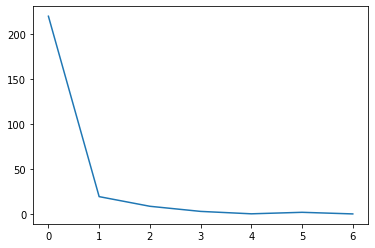

In [237]:
plt.plot(deltas_norms)

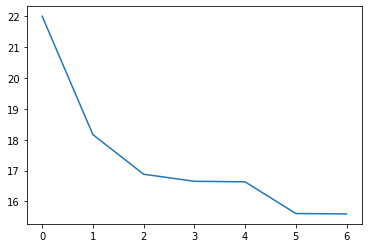

In [238]:
plt.plot(residuals)

In [239]:
trajectory_GT.shape[0]//20

15

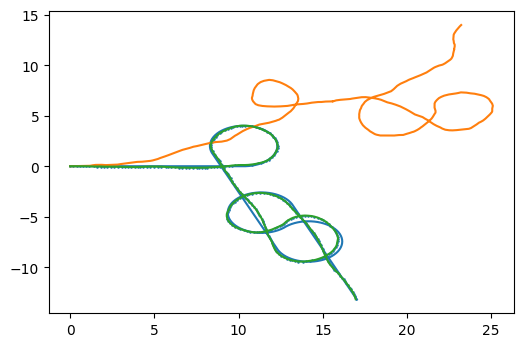

In [240]:
plt.figure(dpi=100)
plt.plot(trajectory_GT[:,0],trajectory_GT[:,1])
plt.plot(noised_trajectory[:,0],noised_trajectory[:,1])
plt.scatter(optimized_poses[:,0],optimized_poses[:,1],s=0.7)
plt.plot(optimized_poses[:,0],optimized_poses[:,1])

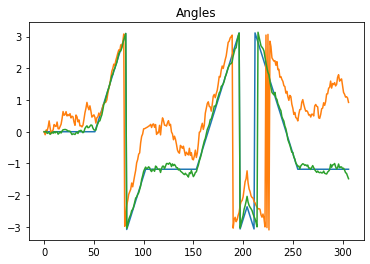

In [241]:
plt.title('Angles')
plt.plot(trajectory_GT[:,2])
plt.plot(noised_trajectory[:,2])
plt.plot(optimized_poses[:,2])

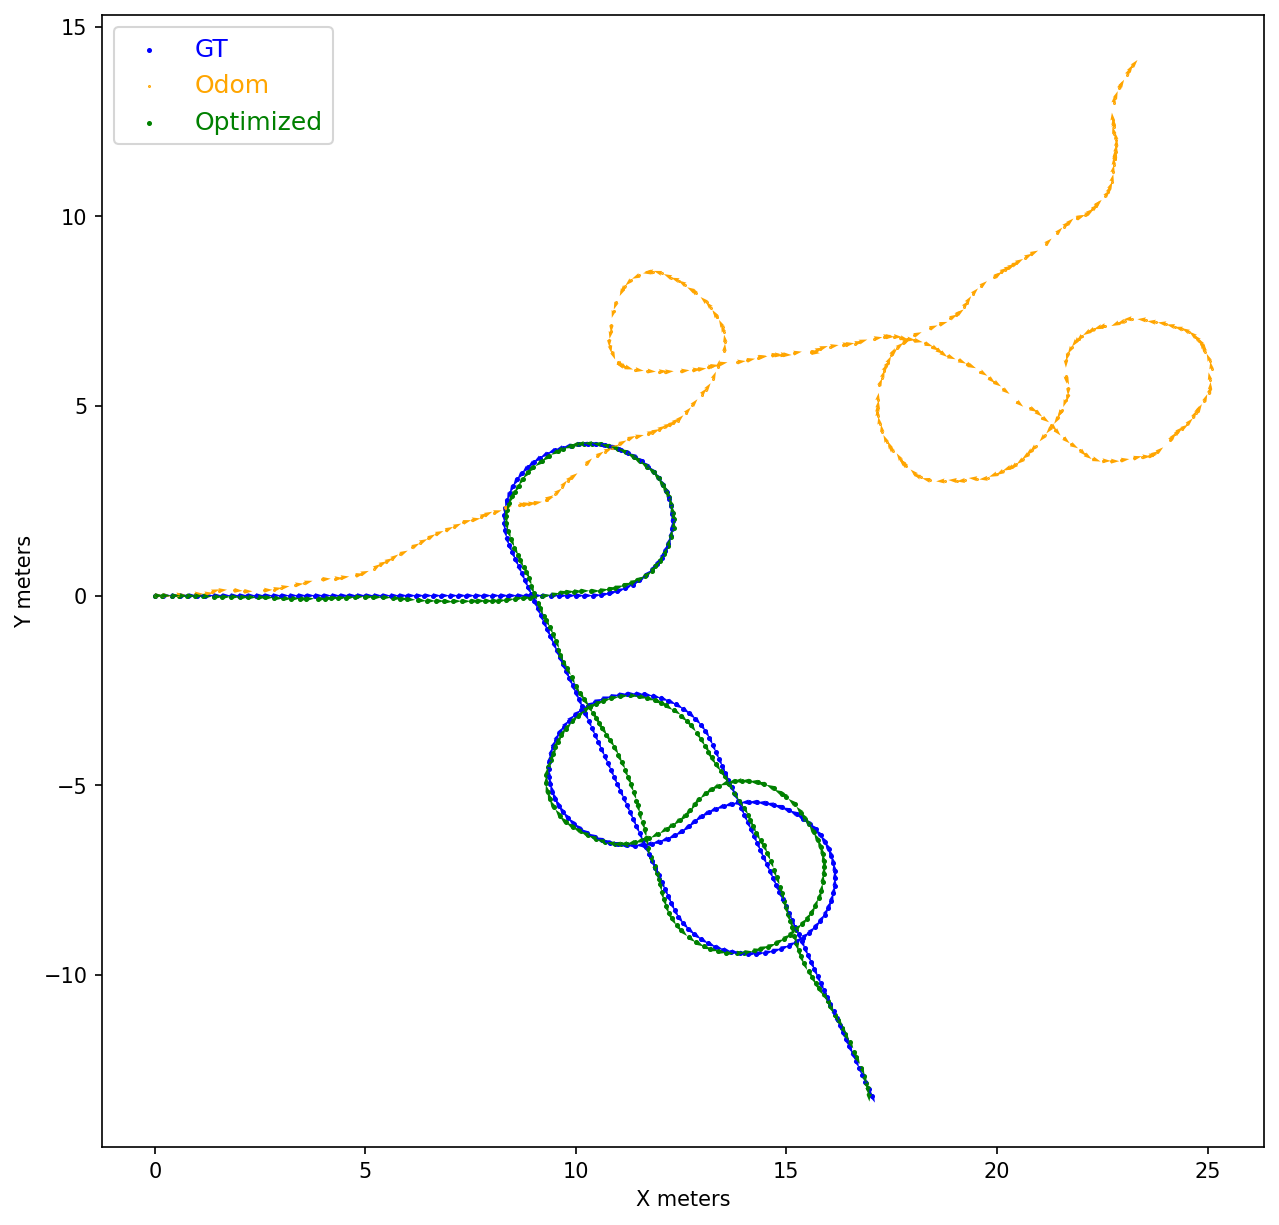

In [242]:
%matplotlib inline
start = 0
k = trajectory_GT.shape[0]
stp = 1
scale = 0.2
fig, ax = plt.subplots(figsize=(10,10),dpi=150)
ax.scatter(trajectory_GT[start:k,0],trajectory_GT[start:k,1], s=2, label='GT',c='blue')
ax.scatter(noised_trajectory[start:k,0],noised_trajectory[start:k,1], s=scale, label='Odom',c='orange')
ax.scatter(optimized_poses[start:k,0],optimized_poses[start:k,1], s=2, label='Optimized',c='green')

legend = ax.legend(loc='upper left', shadow=False, fontsize=12, labelcolor=['blue','orange','green'])
plt.xlabel("X meters")
plt.ylabel("Y meters")

plt.quiver(trajectory_GT[start:k:stp,0],trajectory_GT[start:k:stp,1],
           scale*np.cos(trajectory_GT[start:k:stp,2]),
           scale*np.sin(trajectory_GT[start:k:stp,2]),
           color='blue',width=0.002, angles='xy', scale_units='xy', scale=1.0)

plt.quiver(noised_trajectory[start:k:stp,0],noised_trajectory[start:k:stp,1],
           scale*np.cos(noised_trajectory[start:k:stp,2]),
           scale*np.sin(noised_trajectory[start:k:stp,2]),
           color='orange',width=0.002, angles='xy', scale_units='xy', scale=1.0)

plt.quiver(optimized_poses[start:k:stp,0],optimized_poses[start:k:stp,1],
           scale*np.cos(optimized_poses[start:k:stp,2]),
           scale*np.sin(optimized_poses[start:k:stp,2]),
           color='green',width=0.002, angles='xy', scale_units='xy', scale=1.0)

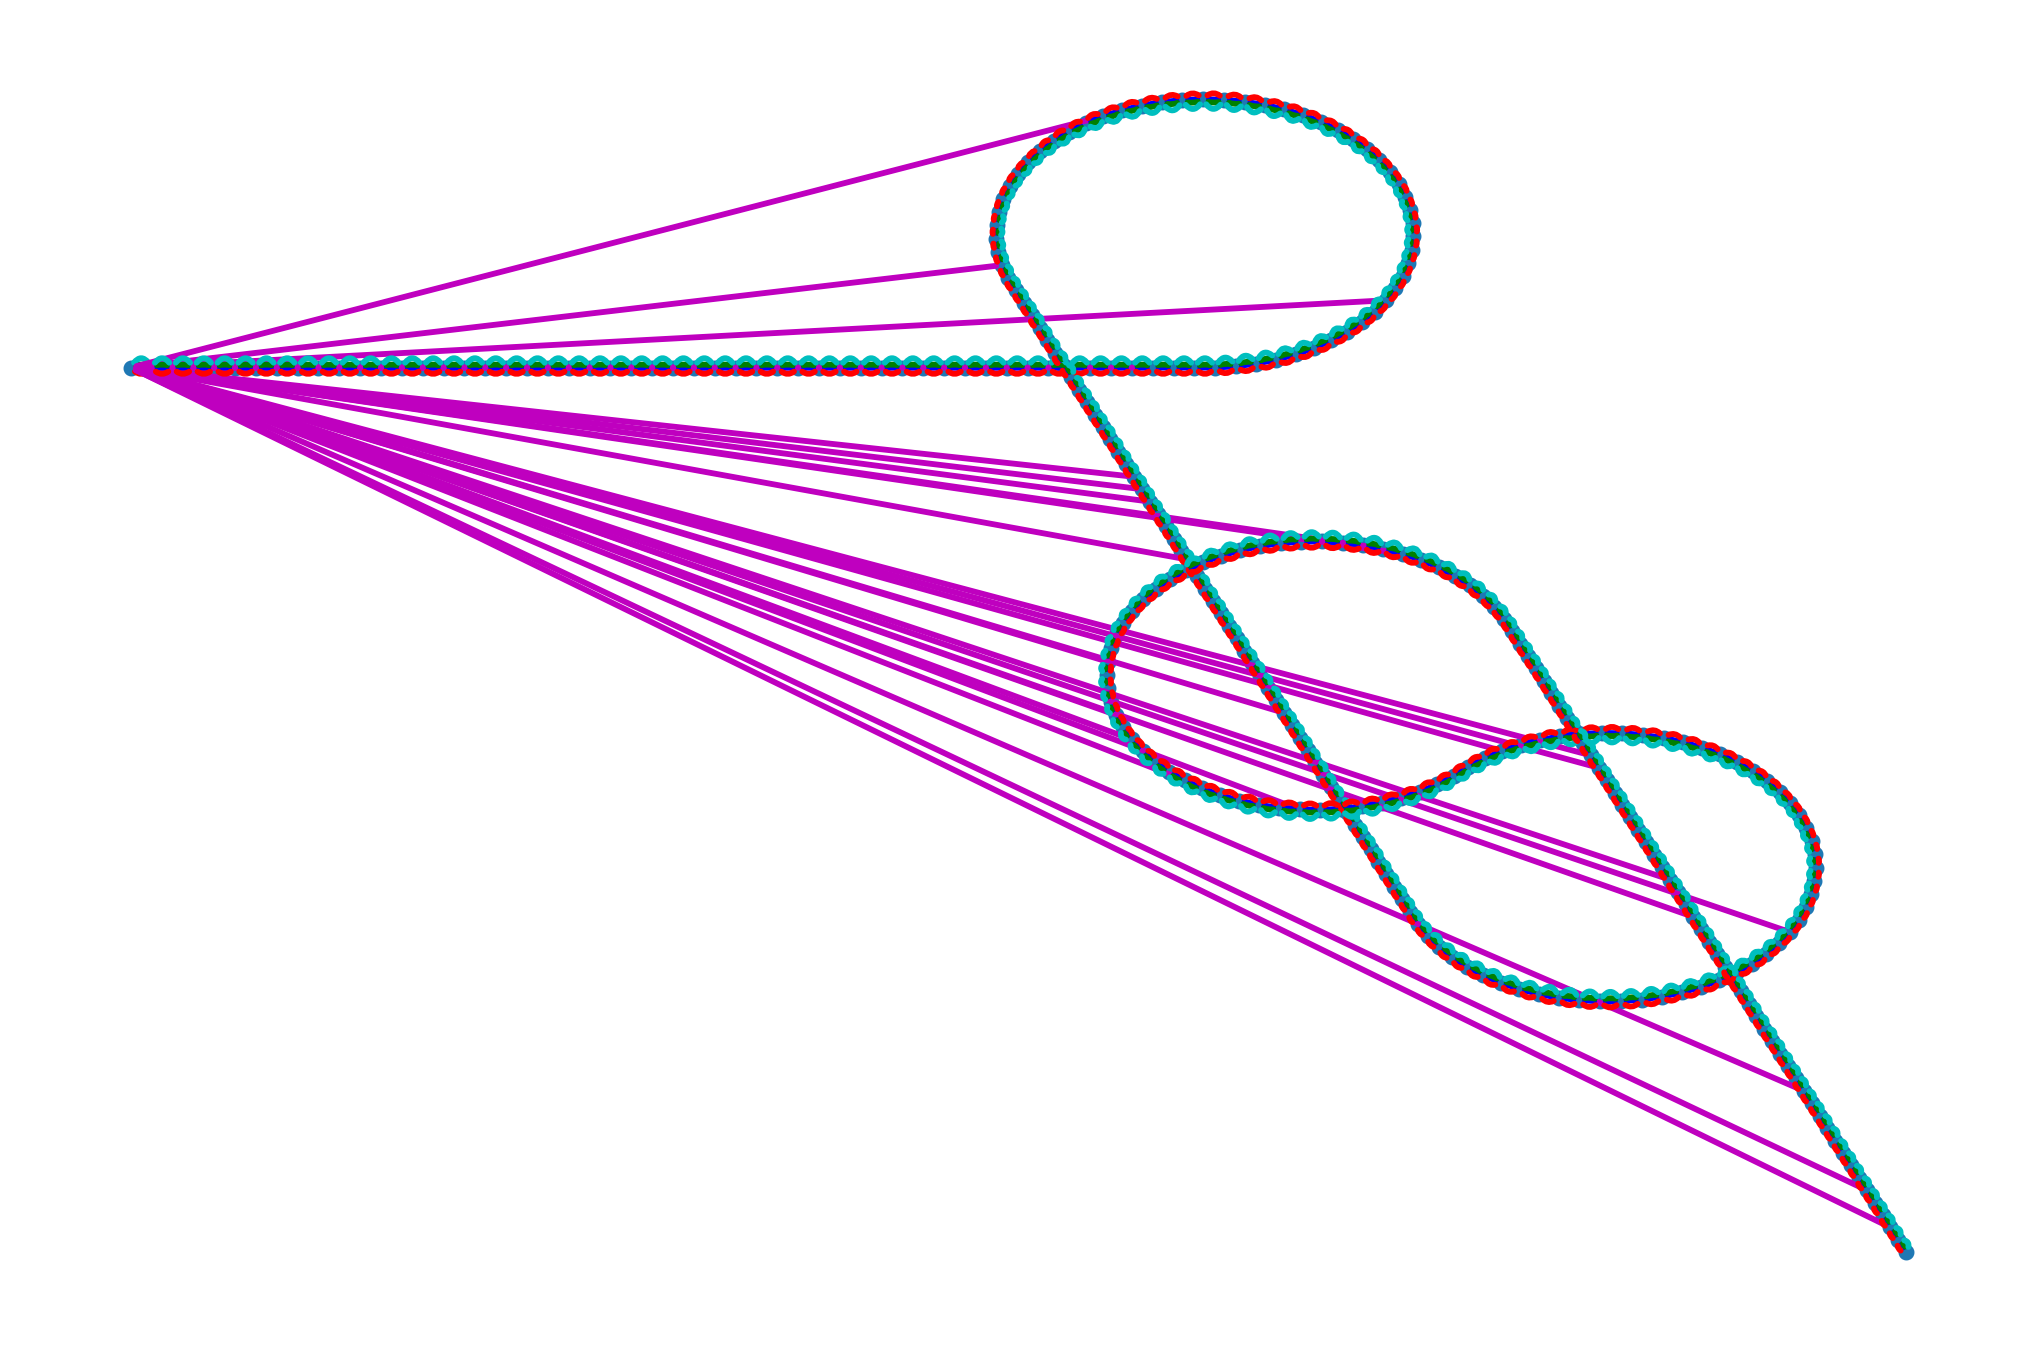

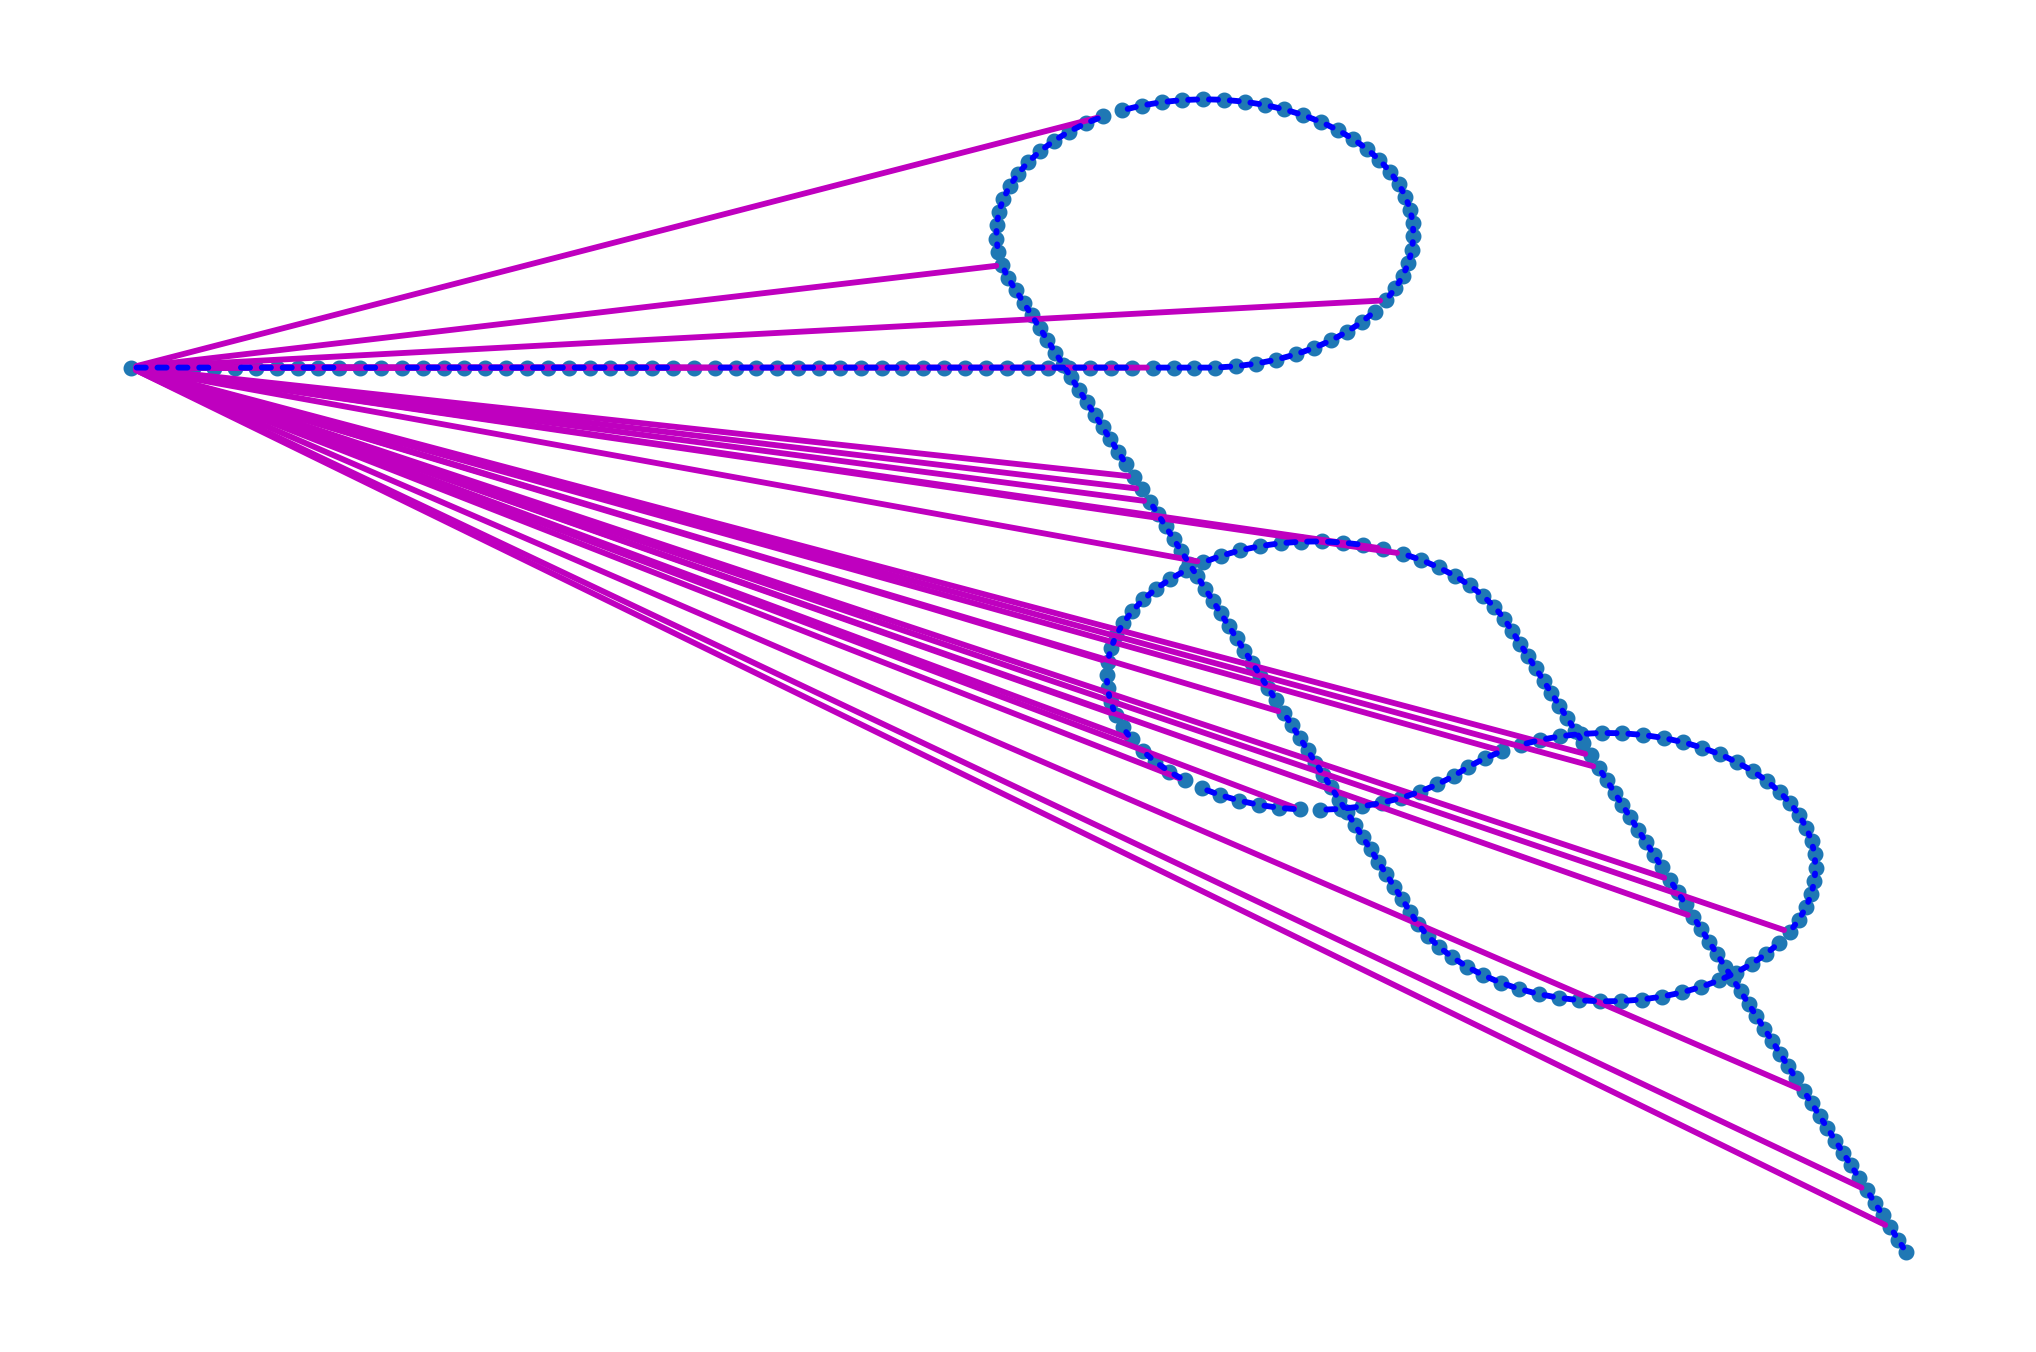

In [257]:
#
# IVAN
#
%matplotlib inline

blue = 'b' 
green = 'g'
red = 'r'
cyan = 'c'
magenta='m'
yellow='y'
black='k'
white='w'


odom_meas_s = np.array([odom_measurements_1, odom_measurements_2, odom_measurements_3, odom_measurements_4])
odom_covs = np.array([odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4])
odom_weights = 1/odom_covs[:, 0, 0, 0]
N = trajectory_GT.shape[0]
loop_weight = 1/loop_covariance[0, 0]
odom_colors = [blue, green, red, cyan]

G = nx.MultiGraph()
for i in range(N):
    G.add_node(int(i))
    
for j, odom_measures in enumerate(odom_meas_s):
    for i, v in enumerate(odom_measures):
        G.add_edge(int(i), int(i+1), weight=odom_weights[j], measurement=v, covariance=odom_covs[j], Type='odom', color=odom_colors[j])

for i in loop_measurements:
    G.add_edge(int(i[0]), int(i[1]), weight=loop_weight, measurement = i[[0, 1, 2, 3, 4]], covariance=loop_covariance, Type='loop', color=magenta)


#colors = [G.edges[e]['color'] for e in G.edges]
#pos = {int(i):trajectory_GT[i, [0, 1]] for i in range(N)}
pos = {int(i):trajectory_GT[i, [0, 1]] for i in range(N)}

plt.figure(figsize=(6, 4), dpi=420)
#nx.draw_networkx_edges(G, pos, width=1, edge_color=colors)
nx.draw_networkx_nodes(G, pos, node_size=3)
ax = plt.gca()
rad = 1
for e in G.edges:
    rad *= -1
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-", color=G.edges[e]["color"],
                                shrinkA=1, shrinkB=1,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2]*rad)
                                ),
                                ),
                )
plt.axis('off')
plt.show()

Tree = nx.algorithms.tree.minimum_spanning_edges(G)
edgelist = list(Tree)
#colors = [G.edges[(e[0], e[1], e[2])]['color'] for e in edgelist]
plt.figure(figsize=(6, 4), dpi=420)
# nx.draw_networkx_edges(G, pos, width=1, edgelist=edgelist, edge_color=colors)
nx.draw_networkx_nodes(G, pos, node_size=3)
ax = plt.gca()
rad = 1
for e in edgelist:
    rad *= -1
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-", color=G.edges[(e[0], e[1], e[2])]["color"],
                                shrinkA=1, shrinkB=1,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2]*rad)
                                ),
                                ),
                )
plt.axis('off')
plt.show()

In [244]:
def solve_tree(poses, edge_list):
    def get_R(phi):
        R = np.array([[cos(phi), -sin(phi),  0],
                        [sin(phi), cos(phi),  0],
                        [0,           0,       1]])
        return R

    assert len(poses) == (len(edge_list)+1)

    solution = np.zeros(shape = (3*len(poses)))
    solution[:3] = poses[0].get_data()
    solution_list = [0]

    for edge in edge_list:
        edge_type = edge[3]['Type']
        measurement = edge[3]['measurement']

        if edge_type == 'odom':
            pose_i_idx = edge[0]
            pose_j_idx = edge[1]
            x, y, phi = solution[3*pose_i_idx:3*(pose_i_idx+1)][0], solution[3*pose_i_idx:3*(pose_i_idx+1)][1], solution[3*pose_i_idx:3*(pose_i_idx+1)][2]
            pose_i = Pose(x, y, phi)
            x = get_g(pose_i, measurement)

        if edge_type == 'loop':
            pose_i_idx = int(measurement[0])
            pose_j_idx = int(measurement[1])
            measurement = measurement[2:]
            if(pose_i_idx > pose_j_idx):
                measurement = -measurement
                tmp = pose_i_idx
                pose_i_idx = pose_j_idx
                pose_j_idx = tmp

            phi = solution[3*pose_i_idx:3*(pose_i_idx+1)][2]
            R = get_R(phi)
            x = solution[3*pose_i_idx:3*(pose_i_idx+1)] + R @ measurement

        solution[3*pose_j_idx: 3*(pose_j_idx+1)] = x
        solution_list.append(pose_j_idx)

    return solution

In [245]:
start = [0, 0, wrap_angle(0/180*np.pi)]
poses = generate_poses(trajectory_GT.shape[0])
poses[0].set_data(start[0], start[1], start[2])
poses = initialize_poses(poses, np.zeros_like(noised_trajectory)) # set init poses with odometry traj

edgelist = sorted(edgelist)
deltas = solve_tree(poses, edgelist)
poses = update_poses(poses, deltas)
ostov_poses = poses_as_array(poses)

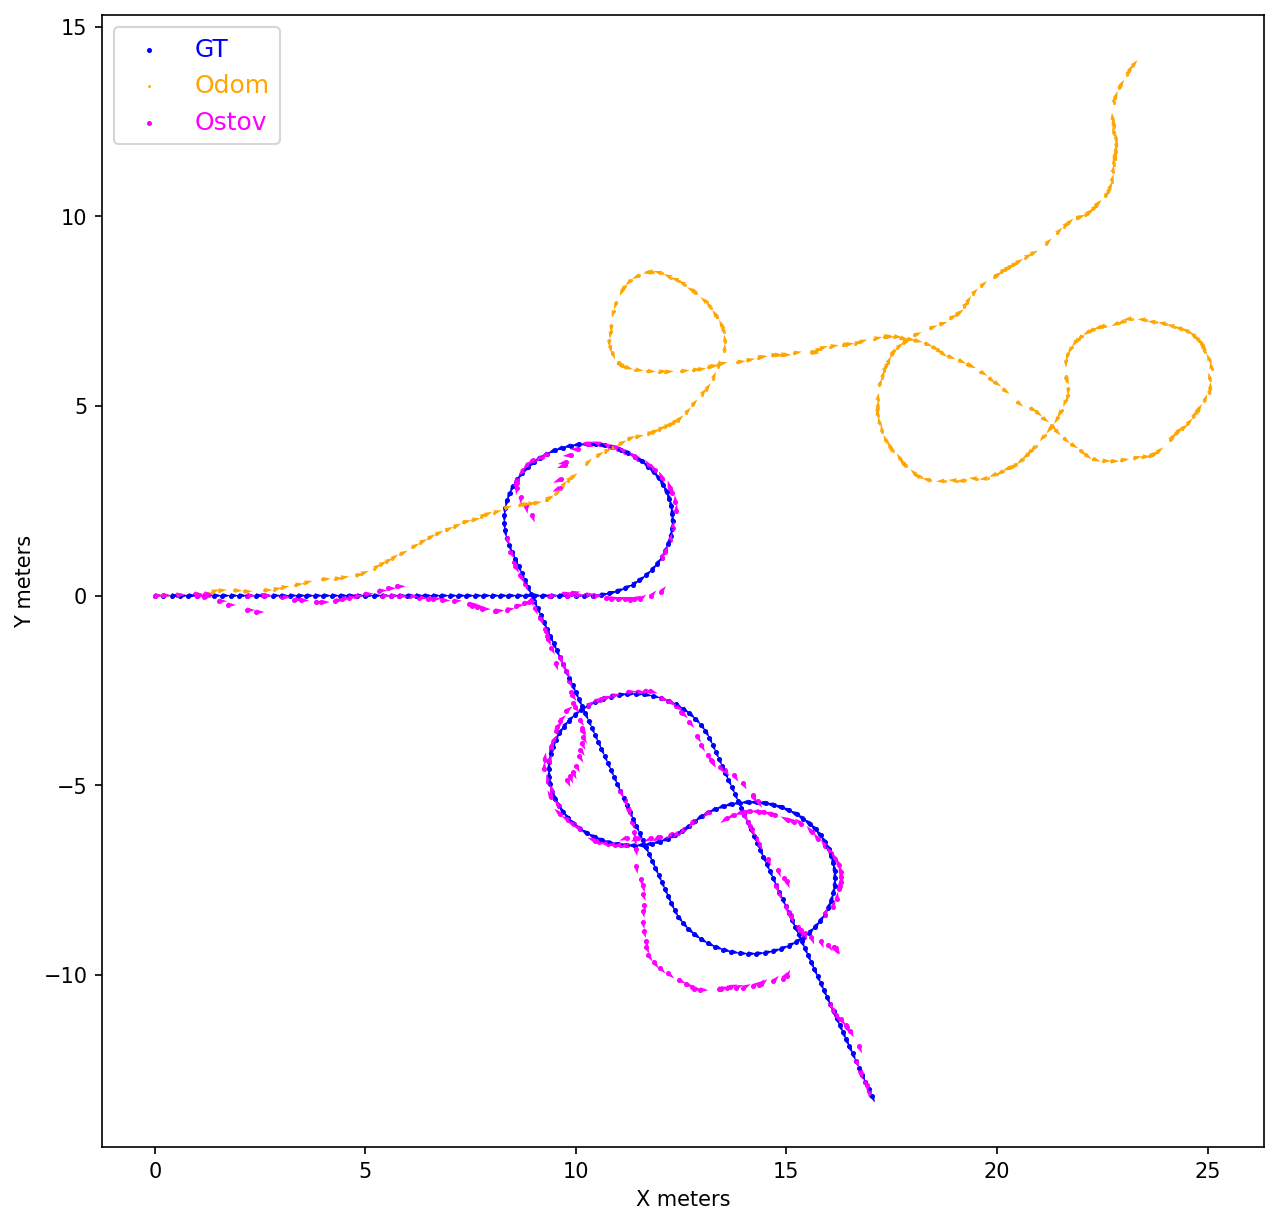

In [246]:
%matplotlib inline
start = 0
k = trajectory_GT.shape[0]
stp = 1
scale = 0.2
fig, ax = plt.subplots(figsize=(10,10),dpi=150)
ax.scatter(trajectory_GT[start:k,0],trajectory_GT[start:k,1], s=2, label='GT',c='blue')
ax.scatter(noised_trajectory[start:k,0],noised_trajectory[start:k,1], s=scale, label='Odom',c='orange')
ax.scatter(ostov_poses[start:k,0],ostov_poses[start:k,1], s=2, label='Ostov',c='magenta')

legend = ax.legend(loc='upper left', shadow=False, fontsize=12, labelcolor=['blue','orange','magenta'])
plt.xlabel("X meters")
plt.ylabel("Y meters")

plt.quiver(trajectory_GT[start:k:stp,0],trajectory_GT[start:k:stp,1],
           scale*np.cos(trajectory_GT[start:k:stp,2]),
           scale*np.sin(trajectory_GT[start:k:stp,2]),
           color='blue',width=0.002, angles='xy', scale_units='xy', scale=1.0)

plt.quiver(noised_trajectory[start:k:stp,0],noised_trajectory[start:k:stp,1],
           scale*np.cos(noised_trajectory[start:k:stp,2]),
           scale*np.sin(noised_trajectory[start:k:stp,2]),
           color='orange',width=0.002, angles='xy', scale_units='xy', scale=1.0)

plt.quiver(ostov_poses[start:k:stp,0],ostov_poses[start:k:stp,1],
           scale*np.cos(optimized_poses[start:k:stp,2]),
           scale*np.sin(optimized_poses[start:k:stp,2]),
           color='magenta',width=0.002, angles='xy', scale_units='xy', scale=1.0)

In [249]:
optimized_poses, residuals, _, trans_mse, rot_mse, chi2 = run_experiment(poses, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = 2)

29.203743918200317
0.010777004716385354 0.008875584734423682
max pos err(m):  0.26
max rot err(deg):  17.02


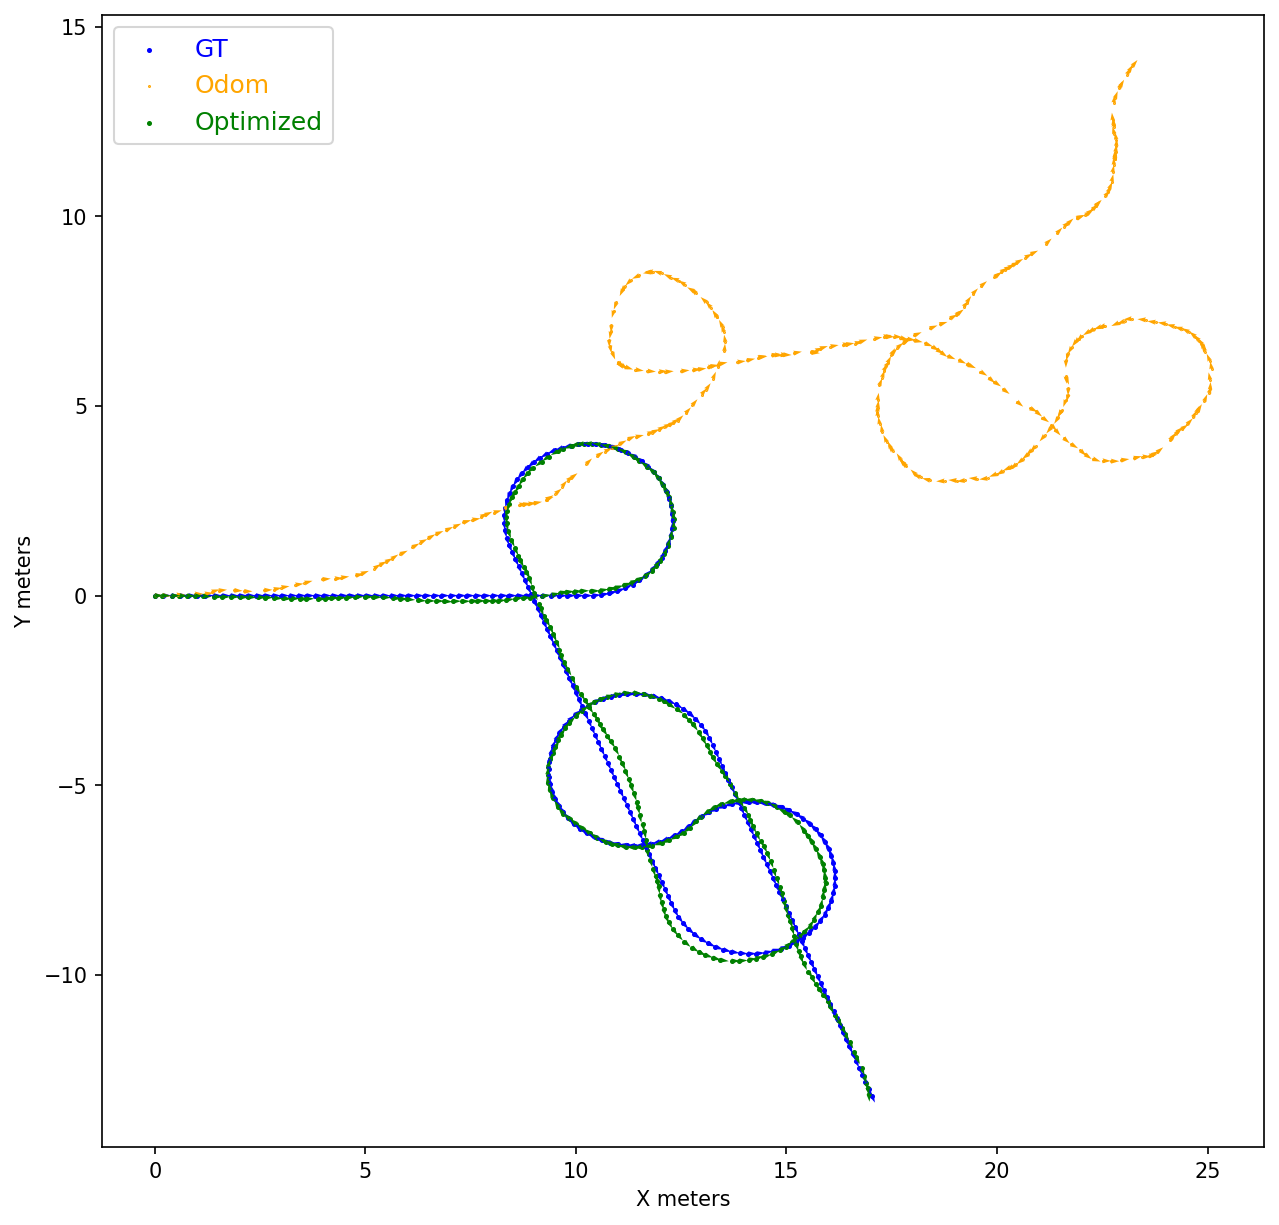

In [250]:
%matplotlib inline
start = 0
k = trajectory_GT.shape[0]
stp = 1
scale = 0.2
fig, ax = plt.subplots(figsize=(10,10),dpi=150)
ax.scatter(trajectory_GT[start:k,0],trajectory_GT[start:k,1], s=2, label='GT',c='blue')
ax.scatter(noised_trajectory[start:k,0],noised_trajectory[start:k,1], s=scale, label='Odom',c='orange')
ax.scatter(optimized_poses[start:k,0],optimized_poses[start:k,1], s=2, label='Optimized',c='green')

legend = ax.legend(loc='upper left', shadow=False, fontsize=12, labelcolor=['blue','orange','green'])
plt.xlabel("X meters")
plt.ylabel("Y meters")

plt.quiver(trajectory_GT[start:k:stp,0],trajectory_GT[start:k:stp,1],
           scale*np.cos(trajectory_GT[start:k:stp,2]),
           scale*np.sin(trajectory_GT[start:k:stp,2]),
           color='blue',width=0.002, angles='xy', scale_units='xy', scale=1.0)

plt.quiver(noised_trajectory[start:k:stp,0],noised_trajectory[start:k:stp,1],
           scale*np.cos(noised_trajectory[start:k:stp,2]),
           scale*np.sin(noised_trajectory[start:k:stp,2]),
           color='orange',width=0.002, angles='xy', scale_units='xy', scale=1.0)

plt.quiver(optimized_poses[start:k:stp,0],optimized_poses[start:k:stp,1],
           scale*np.cos(optimized_poses[start:k:stp,2]),
           scale*np.sin(optimized_poses[start:k:stp,2]),
           color='green',width=0.002, angles='xy', scale_units='xy', scale=1.0)